In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import random
import matplotlib.pyplot as plt
import time
from tqdm import tqdm 

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [32]:
data_dir = 'D:/processed_plantas'
categories = ['arocarbol', 'durazno', 'guayabilla', 'matico', 'tuna']

# Recopilacion de rutas de imagenes y etiquetas
image_paths = []
labels = []

for label, category in enumerate(categories):
    category_path = os.path.join(data_dir, category)
    for img_path in glob.glob(os.path.join(category_path, '*.jpg')):
        image_paths.append(img_path)
        labels.append(label)

#for label, category in enumerate(categories):
    #category_path = os.path.join(data_dir, category)
    #img_paths = glob.glob(os.path.join(category_path, '*.jpg'))
    #img_paths = random.sample(img_paths, min(10, len(img_paths)))
    #for img_path in img_paths:
        #image_paths.append(img_path)
        #labels.append(label)

# Division de los datos en entrenamiento y validacion
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


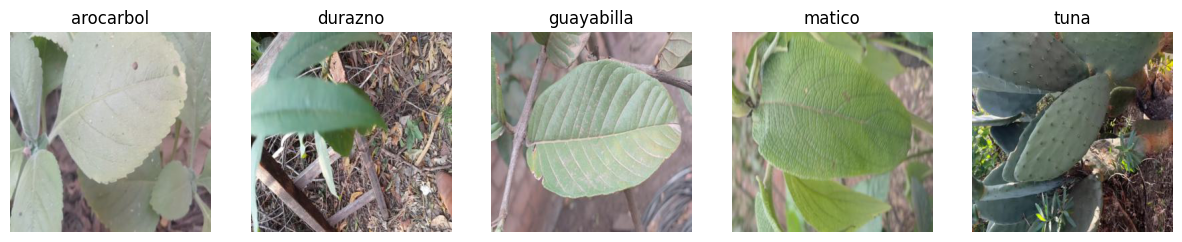

In [33]:
# Funcion para mostrar imagenes del dataset
def show_sample_images(categories, data_dir):
    fig, axs = plt.subplots(1, len(categories), figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(data_dir, category)
        img_names = os.listdir(category_path)
        img_path = os.path.join(category_path, random.choice(img_names))
        image = Image.open(img_path)
        axs[i].imshow(image)
        axs[i].set_title(f'{category.split()[0]}')
        axs[i].axis('off')
    plt.show()

show_sample_images(categories, data_dir)

In [34]:
# Definir Dataset personalizado
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Definir transformaciones
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Creacion Dataset y DataLoader
train_dataset = CustomDataset(train_paths, train_labels, transform=data_transforms)
val_dataset = CustomDataset(val_paths, val_labels, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [35]:
# Cargar el modelo ResNet18 preentrenado
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar las capas del modelo base
for param in model_ft.parameters():
    param.requires_grad = False

# Modificar la última capa del modelo
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(categories))

# Mover el modelo a la GPU
model_ft = model_ft.to(device)
print(f'Model is on: {next(model_ft.parameters()).device}')

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)

Model is on: cuda:0


In [36]:
# Función para entrenar el modelo
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Inicia el contador del tiempo
        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Inicia el contador de memoria
            if torch.cuda.is_available():
                torch.cuda.reset_peak_memory_stats()
                initial_memory = torch.cuda.memory_allocated()

            # Iterar sobre los datos
            data_loader = train_loader if phase == 'train' else val_loader
            with tqdm(data_loader, desc=f'{phase} Phase', unit='batch') as pbar:
                for inputs, labels in pbar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Resetear los gradientes
                    optimizer.zero_grad()

                    # Adelante
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Retropropagación y optimización
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Actualizar la barra de progreso
                    pbar.set_postfix(loss=running_loss / (inputs.size(0) * (pbar.n + 1)),
                                     accuracy=running_corrects.double() / (inputs.size(0) * (pbar.n + 1)))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calcular el tiempo final de cada fase
            epoch_time = time.time() - epoch_start_time

            # Calcular el uso de memoria
            if torch.cuda.is_available():
                peak_memory = torch.cuda.max_memory_allocated() - initial_memory
                memory_used = peak_memory / (1024 ** 2)
            else:
                memory_used = 0

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(f'{phase} Time: {epoch_time:.2f} seconds')
            print(f'{phase} Memory Used: {memory_used:.2f} MB')

    return model

# Entrenar el modelo (10 épocas)
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------


train Phase: 100%|██████████| 1875/1875 [06:28<00:00,  4.82batch/s, accuracy=tensor(0.9272, device='cuda:0', dtype=torch.float64), loss=0.259]


train Loss: 0.2586 Acc: 0.9272
train Time: 388.91 seconds
train Memory Used: 384.98 MB


val Phase: 100%|██████████| 469/469 [01:47<00:00,  4.35batch/s, accuracy=tensor(1.2856, device='cuda:0', dtype=torch.float64), loss=0.154]


val Loss: 0.1153 Acc: 0.9647
val Time: 496.82 seconds
val Memory Used: 351.99 MB
Epoch 1/9
----------


train Phase: 100%|██████████| 1875/1875 [07:30<00:00,  4.17batch/s, accuracy=tensor(0.9592, device='cuda:0', dtype=torch.float64), loss=0.128]


train Loss: 0.1285 Acc: 0.9592
train Time: 450.05 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:58<00:00,  3.95batch/s, accuracy=tensor(1.2936, device='cuda:0', dtype=torch.float64), loss=0.117] 


val Loss: 0.0881 Acc: 0.9707
val Time: 568.82 seconds
val Memory Used: 351.99 MB
Epoch 2/9
----------


train Phase: 100%|██████████| 1875/1875 [07:55<00:00,  3.94batch/s, accuracy=tensor(0.9625, device='cuda:0', dtype=torch.float64), loss=0.112]


train Loss: 0.1122 Acc: 0.9625
train Time: 475.75 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:57<00:00,  3.99batch/s, accuracy=tensor(1.2967, device='cuda:0', dtype=torch.float64), loss=0.108] 


val Loss: 0.0814 Acc: 0.9731
val Time: 593.23 seconds
val Memory Used: 351.99 MB
Epoch 3/9
----------


train Phase: 100%|██████████| 1875/1875 [07:46<00:00,  4.02batch/s, accuracy=tensor(0.9644, device='cuda:0', dtype=torch.float64), loss=0.104]


train Loss: 0.1045 Acc: 0.9644
train Time: 466.18 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:56<00:00,  4.01batch/s, accuracy=tensor(1.2910, device='cuda:0', dtype=torch.float64), loss=0.121] 


val Loss: 0.0909 Acc: 0.9688
val Time: 583.11 seconds
val Memory Used: 351.99 MB
Epoch 4/9
----------


train Phase: 100%|██████████| 1875/1875 [07:38<00:00,  4.09batch/s, accuracy=tensor(0.9653, device='cuda:0', dtype=torch.float64), loss=0.101]


train Loss: 0.1011 Acc: 0.9653
train Time: 458.24 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [02:04<00:00,  3.78batch/s, accuracy=tensor(1.3020, device='cuda:0', dtype=torch.float64), loss=0.0931]


val Loss: 0.0699 Acc: 0.9770
val Time: 582.38 seconds
val Memory Used: 351.99 MB
Epoch 5/9
----------


train Phase: 100%|██████████| 1875/1875 [07:50<00:00,  3.98batch/s, accuracy=tensor(0.9674, device='cuda:0', dtype=torch.float64), loss=0.0946]


train Loss: 0.0946 Acc: 0.9674
train Time: 470.57 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:59<00:00,  3.93batch/s, accuracy=tensor(1.3002, device='cuda:0', dtype=torch.float64), loss=0.0948]


val Loss: 0.0711 Acc: 0.9757
val Time: 589.77 seconds
val Memory Used: 351.99 MB
Epoch 6/9
----------


train Phase: 100%|██████████| 1875/1875 [08:06<00:00,  3.85batch/s, accuracy=tensor(0.9664, device='cuda:0', dtype=torch.float64), loss=0.0953]


train Loss: 0.0953 Acc: 0.9664
train Time: 486.73 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:49<00:00,  4.30batch/s, accuracy=tensor(1.3027, device='cuda:0', dtype=torch.float64), loss=0.0904]


val Loss: 0.0678 Acc: 0.9775
val Time: 595.90 seconds
val Memory Used: 351.99 MB
Epoch 7/9
----------


train Phase: 100%|██████████| 1875/1875 [08:07<00:00,  3.85batch/s, accuracy=tensor(0.9688, device='cuda:0', dtype=torch.float64), loss=0.0906]


train Loss: 0.0906 Acc: 0.9688
train Time: 487.42 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:50<00:00,  4.26batch/s, accuracy=tensor(1.2974, device='cuda:0', dtype=torch.float64), loss=0.101] 


val Loss: 0.0756 Acc: 0.9735
val Time: 597.53 seconds
val Memory Used: 351.99 MB
Epoch 8/9
----------


train Phase: 100%|██████████| 1875/1875 [07:36<00:00,  4.11batch/s, accuracy=tensor(0.9690, device='cuda:0', dtype=torch.float64), loss=0.0895]


train Loss: 0.0895 Acc: 0.9690
train Time: 456.25 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:57<00:00,  3.98batch/s, accuracy=tensor(1.3045, device='cuda:0', dtype=torch.float64), loss=0.0836]


val Loss: 0.0627 Acc: 0.9789
val Time: 574.20 seconds
val Memory Used: 351.99 MB
Epoch 9/9
----------


train Phase: 100%|██████████| 1875/1875 [07:23<00:00,  4.23batch/s, accuracy=tensor(0.9689, device='cuda:0', dtype=torch.float64), loss=0.087] 


train Loss: 0.0870 Acc: 0.9689
train Time: 443.68 seconds
train Memory Used: 360.24 MB


val Phase: 100%|██████████| 469/469 [01:51<00:00,  4.19batch/s, accuracy=tensor(1.2971, device='cuda:0', dtype=torch.float64), loss=0.0972]

val Loss: 0.0730 Acc: 0.9733
val Time: 555.58 seconds
val Memory Used: 351.99 MB


In [37]:
# Descongelar las capas del modelo para Fine-Tuning
for param in model_ft.parameters():
    param.requires_grad = True

# Definir el optimizador para Fine-Tuning
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-5)

# Entrenar el modelo con Fine-Tuning (10 épocas más)
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------


train Phase: 100%|██████████| 1875/1875 [16:59<00:00,  1.84batch/s, accuracy=tensor(0.9876, device='cuda:0', dtype=torch.float64), loss=0.0365]


train Loss: 0.0365 Acc: 0.9876
train Time: 1019.83 seconds
train Memory Used: 1408.82 MB


val Phase: 100%|██████████| 469/469 [01:54<00:00,  4.11batch/s, accuracy=tensor(1.3266, device='cuda:0', dtype=torch.float64), loss=0.0177]


val Loss: 0.0133 Acc: 0.9955
val Time: 1133.90 seconds
val Memory Used: 309.10 MB
Epoch 1/9
----------


train Phase: 100%|██████████| 1875/1875 [16:37<00:00,  1.88batch/s, accuracy=tensor(0.9980, device='cuda:0', dtype=torch.float64), loss=0.0066] 


train Loss: 0.0066 Acc: 0.9980
train Time: 997.79 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:50<00:00,  4.25batch/s, accuracy=tensor(1.3278, device='cuda:0', dtype=torch.float64), loss=0.0128] 


val Loss: 0.0096 Acc: 0.9964
val Time: 1108.28 seconds
val Memory Used: 309.10 MB
Epoch 2/9
----------


train Phase: 100%|██████████| 1875/1875 [16:19<00:00,  1.91batch/s, accuracy=tensor(0.9986, device='cuda:0', dtype=torch.float64), loss=0.0044] 


train Loss: 0.0044 Acc: 0.9986
train Time: 979.15 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:49<00:00,  4.29batch/s, accuracy=tensor(1.3286, device='cuda:0', dtype=torch.float64), loss=0.0116] 


val Loss: 0.0087 Acc: 0.9970
val Time: 1088.55 seconds
val Memory Used: 309.10 MB
Epoch 3/9
----------


train Phase: 100%|██████████| 1875/1875 [16:13<00:00,  1.93batch/s, accuracy=tensor(0.9990, device='cuda:0', dtype=torch.float64), loss=0.00321]


train Loss: 0.0032 Acc: 0.9990
train Time: 973.67 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:42<00:00,  4.56batch/s, accuracy=tensor(1.3282, device='cuda:0', dtype=torch.float64), loss=0.0155]


val Loss: 0.0116 Acc: 0.9967
val Time: 1076.45 seconds
val Memory Used: 309.10 MB
Epoch 4/9
----------


train Phase: 100%|██████████| 1875/1875 [19:32<00:00,  1.60batch/s, accuracy=tensor(0.9994, device='cuda:0', dtype=torch.float64), loss=0.00225]


train Loss: 0.0023 Acc: 0.9994
train Time: 1172.98 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [03:23<00:00,  2.30batch/s, accuracy=tensor(1.3284, device='cuda:0', dtype=torch.float64), loss=0.0131] 


val Loss: 0.0098 Acc: 0.9968
val Time: 1376.96 seconds
val Memory Used: 309.10 MB
Epoch 5/9
----------


train Phase: 100%|██████████| 1875/1875 [18:40<00:00,  1.67batch/s, accuracy=tensor(0.9994, device='cuda:0', dtype=torch.float64), loss=0.00171]


train Loss: 0.0017 Acc: 0.9994
train Time: 1120.36 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:46<00:00,  4.39batch/s, accuracy=tensor(1.3292, device='cuda:0', dtype=torch.float64), loss=0.0109] 


val Loss: 0.0082 Acc: 0.9974
val Time: 1227.29 seconds
val Memory Used: 309.10 MB
Epoch 6/9
----------


train Phase: 100%|██████████| 1875/1875 [16:09<00:00,  1.93batch/s, accuracy=tensor(0.9994, device='cuda:0', dtype=torch.float64), loss=0.00208]


train Loss: 0.0021 Acc: 0.9994
train Time: 969.44 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:48<00:00,  4.31batch/s, accuracy=tensor(1.3258, device='cuda:0', dtype=torch.float64), loss=0.0257]


val Loss: 0.0193 Acc: 0.9949
val Time: 1078.38 seconds
val Memory Used: 309.10 MB
Epoch 7/9
----------


train Phase: 100%|██████████| 1875/1875 [16:03<00:00,  1.95batch/s, accuracy=tensor(0.9994, device='cuda:0', dtype=torch.float64), loss=0.00186]


train Loss: 0.0019 Acc: 0.9994
train Time: 963.53 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:43<00:00,  4.53batch/s, accuracy=tensor(1.3297, device='cuda:0', dtype=torch.float64), loss=0.00885]


val Loss: 0.0066 Acc: 0.9978
val Time: 1067.12 seconds
val Memory Used: 309.10 MB
Epoch 8/9
----------


train Phase: 100%|██████████| 1875/1875 [15:58<00:00,  1.96batch/s, accuracy=tensor(0.9998, device='cuda:0', dtype=torch.float64), loss=0.000769]


train Loss: 0.0008 Acc: 0.9998
train Time: 958.18 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:42<00:00,  4.59batch/s, accuracy=tensor(1.3301, device='cuda:0', dtype=torch.float64), loss=0.00848]


val Loss: 0.0064 Acc: 0.9981
val Time: 1060.42 seconds
val Memory Used: 309.10 MB
Epoch 9/9
----------


train Phase: 100%|██████████| 1875/1875 [15:46<00:00,  1.98batch/s, accuracy=tensor(0.9995, device='cuda:0', dtype=torch.float64), loss=0.00137]


train Loss: 0.0014 Acc: 0.9995
train Time: 946.04 seconds
train Memory Used: 1297.68 MB


val Phase: 100%|██████████| 469/469 [01:44<00:00,  4.48batch/s, accuracy=tensor(1.3300, device='cuda:0', dtype=torch.float64), loss=0.00805]

val Loss: 0.0060 Acc: 0.9980
val Time: 1050.62 seconds
val Memory Used: 309.10 MB


In [38]:
# Función para evaluar el modelo
def evaluate_model(model):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / dataset_sizes['val'] * 100
    print(f'Validation Accuracy: {accuracy:.2f}')

# Evaluar el modelo
evaluate_model(model_ft)

Validation Accuracy: 99.80
